In [60]:

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# 전처리 및 머신 러닝 알고리즘
from sklearn.preprocessing import StandardScaler

# 모델 튜닝 및 평가
from sklearn.model_selection import cross_val_score

from pandas_profiling import ProfileReport
from datetime import datetime


# 경고 제거 (판다스가 에러 메세지를 자주 만들어 내기 때문에 이를 일단 무시하도록 설정합니다.)
import sys
import warnings

import warnings
warnings.filterwarnings('ignore')
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8


In [61]:
from sklearn.datasets import load_boston

boston = load_boston()
print(f"Number of Data points: {boston.data.shape[0]}")
bytes_orig = boston.data.nbytes
print(f"Data nbytes: {bytes_orig}")


Number of Data points: 506
Data nbytes: 52624


* 데이터 전처리 *-> train dataset만 보고 파악할 수 있음.*
    * text -> 숫자 
    * 빠진거 채우기
    * 등...

**그렇기 때문에 데이터 로딩을 한 후에 바로 train과 test dataset으로 나눠야함.**

In [62]:
from sklearn.model_selection import train_test_split
x_trainval, x_test, y_trainval, y_test = train_test_split(boston.data,boston.target,test_size=0.2,random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval,test_size=0.25,random_state=13)

In [63]:
pd_train = pd.DataFrame(x_train, columns=boston.feature_names)
pd_train["PRICE"] = y_train

print('\033[0m\033[94m*' * 21)
print('\033[94m\033[1m'+'.: Train Dataset :.')
print('\033[0m\033[94m*' * 21)
pd_train.head().style.background_gradient(cmap="Greens").set_properties(**{'font-family': 'Segoe UI'}).hide_index()

*********************
.: Train Dataset :.
*********************


CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0.140520,0.000000,10.590000,0.000000,0.489000,6.375000,32.300000,3.945400,4.000000,277.000000,18.600000,385.810000,9.380000,28.100000
0.064170,0.000000,5.960000,0.000000,0.499000,5.933000,68.200000,3.360300,5.000000,279.000000,19.200000,396.900000,9.680000,18.900000
25.046100,0.000000,18.100000,0.000000,0.693000,5.987000,100.000000,1.588800,24.000000,666.000000,20.200000,396.900000,26.770000,5.600000
0.852040,0.000000,8.140000,0.000000,0.538000,5.965000,89.200000,4.012300,4.000000,307.000000,21.000000,392.530000,13.830000,19.600000
0.219770,0.000000,6.910000,0.000000,0.448000,5.602000,62.000000,6.087700,3.000000,233.000000,17.900000,396.900000,16.200000,19.400000


In [64]:
pd_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     303 non-null    float64
 1   ZN       303 non-null    float64
 2   INDUS    303 non-null    float64
 3   CHAS     303 non-null    float64
 4   NOX      303 non-null    float64
 5   RM       303 non-null    float64
 6   AGE      303 non-null    float64
 7   DIS      303 non-null    float64
 8   RAD      303 non-null    float64
 9   TAX      303 non-null    float64
 10  PTRATIO  303 non-null    float64
 11  B        303 non-null    float64
 12  LSTAT    303 non-null    float64
 13  PRICE    303 non-null    float64
dtypes: float64(14)
memory usage: 33.3 KB


In [65]:
ProfileReport(pd_train, title='Dataset', minimal=True, progress_bar=False, 
              samples=None, correlations=None, interactions=None, explorative=True, dark_mode=True,
              notebook={'iframe':{'height': '600px'}},
              html={'style':{'primary_color': '#219EBC'}},
              missing_diagrams={'heatmap': False, 'dendrogram': False}).to_notebook_iframe()

**Boston Dataset에 대한 column을 이해하기 위해서 검색함**

https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

> There are 14 attributes in each case of the dataset. They are:
> <ul>
>    <li> CRIM - per capita crime rate by town </li>
>    <li> ZN - proportion of residential land zoned for lots over 25,000 sq.ft.</li>
>    <li> INDUS - proportion of non-retail business acres per town. </li>
>    <li> CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise) </li>
>    <li> NOX - nitric oxides concentration (parts per 10 million) </li>
>    <li> RM - average number of rooms per dwelling </li>
>    <li> AGE - proportion of owner-occupied units built prior to 1940 </li>
>    <li> DIS - weighted distances to five Boston employment centres</li>
>    <li> RAD - index of accessibility to radial highways</li>
>    <li> TAX - full-value property-tax rate per $10,000</li>
>    <li> PTRATIO - pupil-teacher ratio by town  </li>
>    <li> B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town  </li>
>    <li> LSTAT - % lower status of the population  </li>
>    <li> MEDV - Median value of owner-occupied homes in $1000's  </li>
> </ul>

**그래서 `ZN`이랑 `CHAS`가  각각 값이 0이 많은 이유는 합당하다.** 

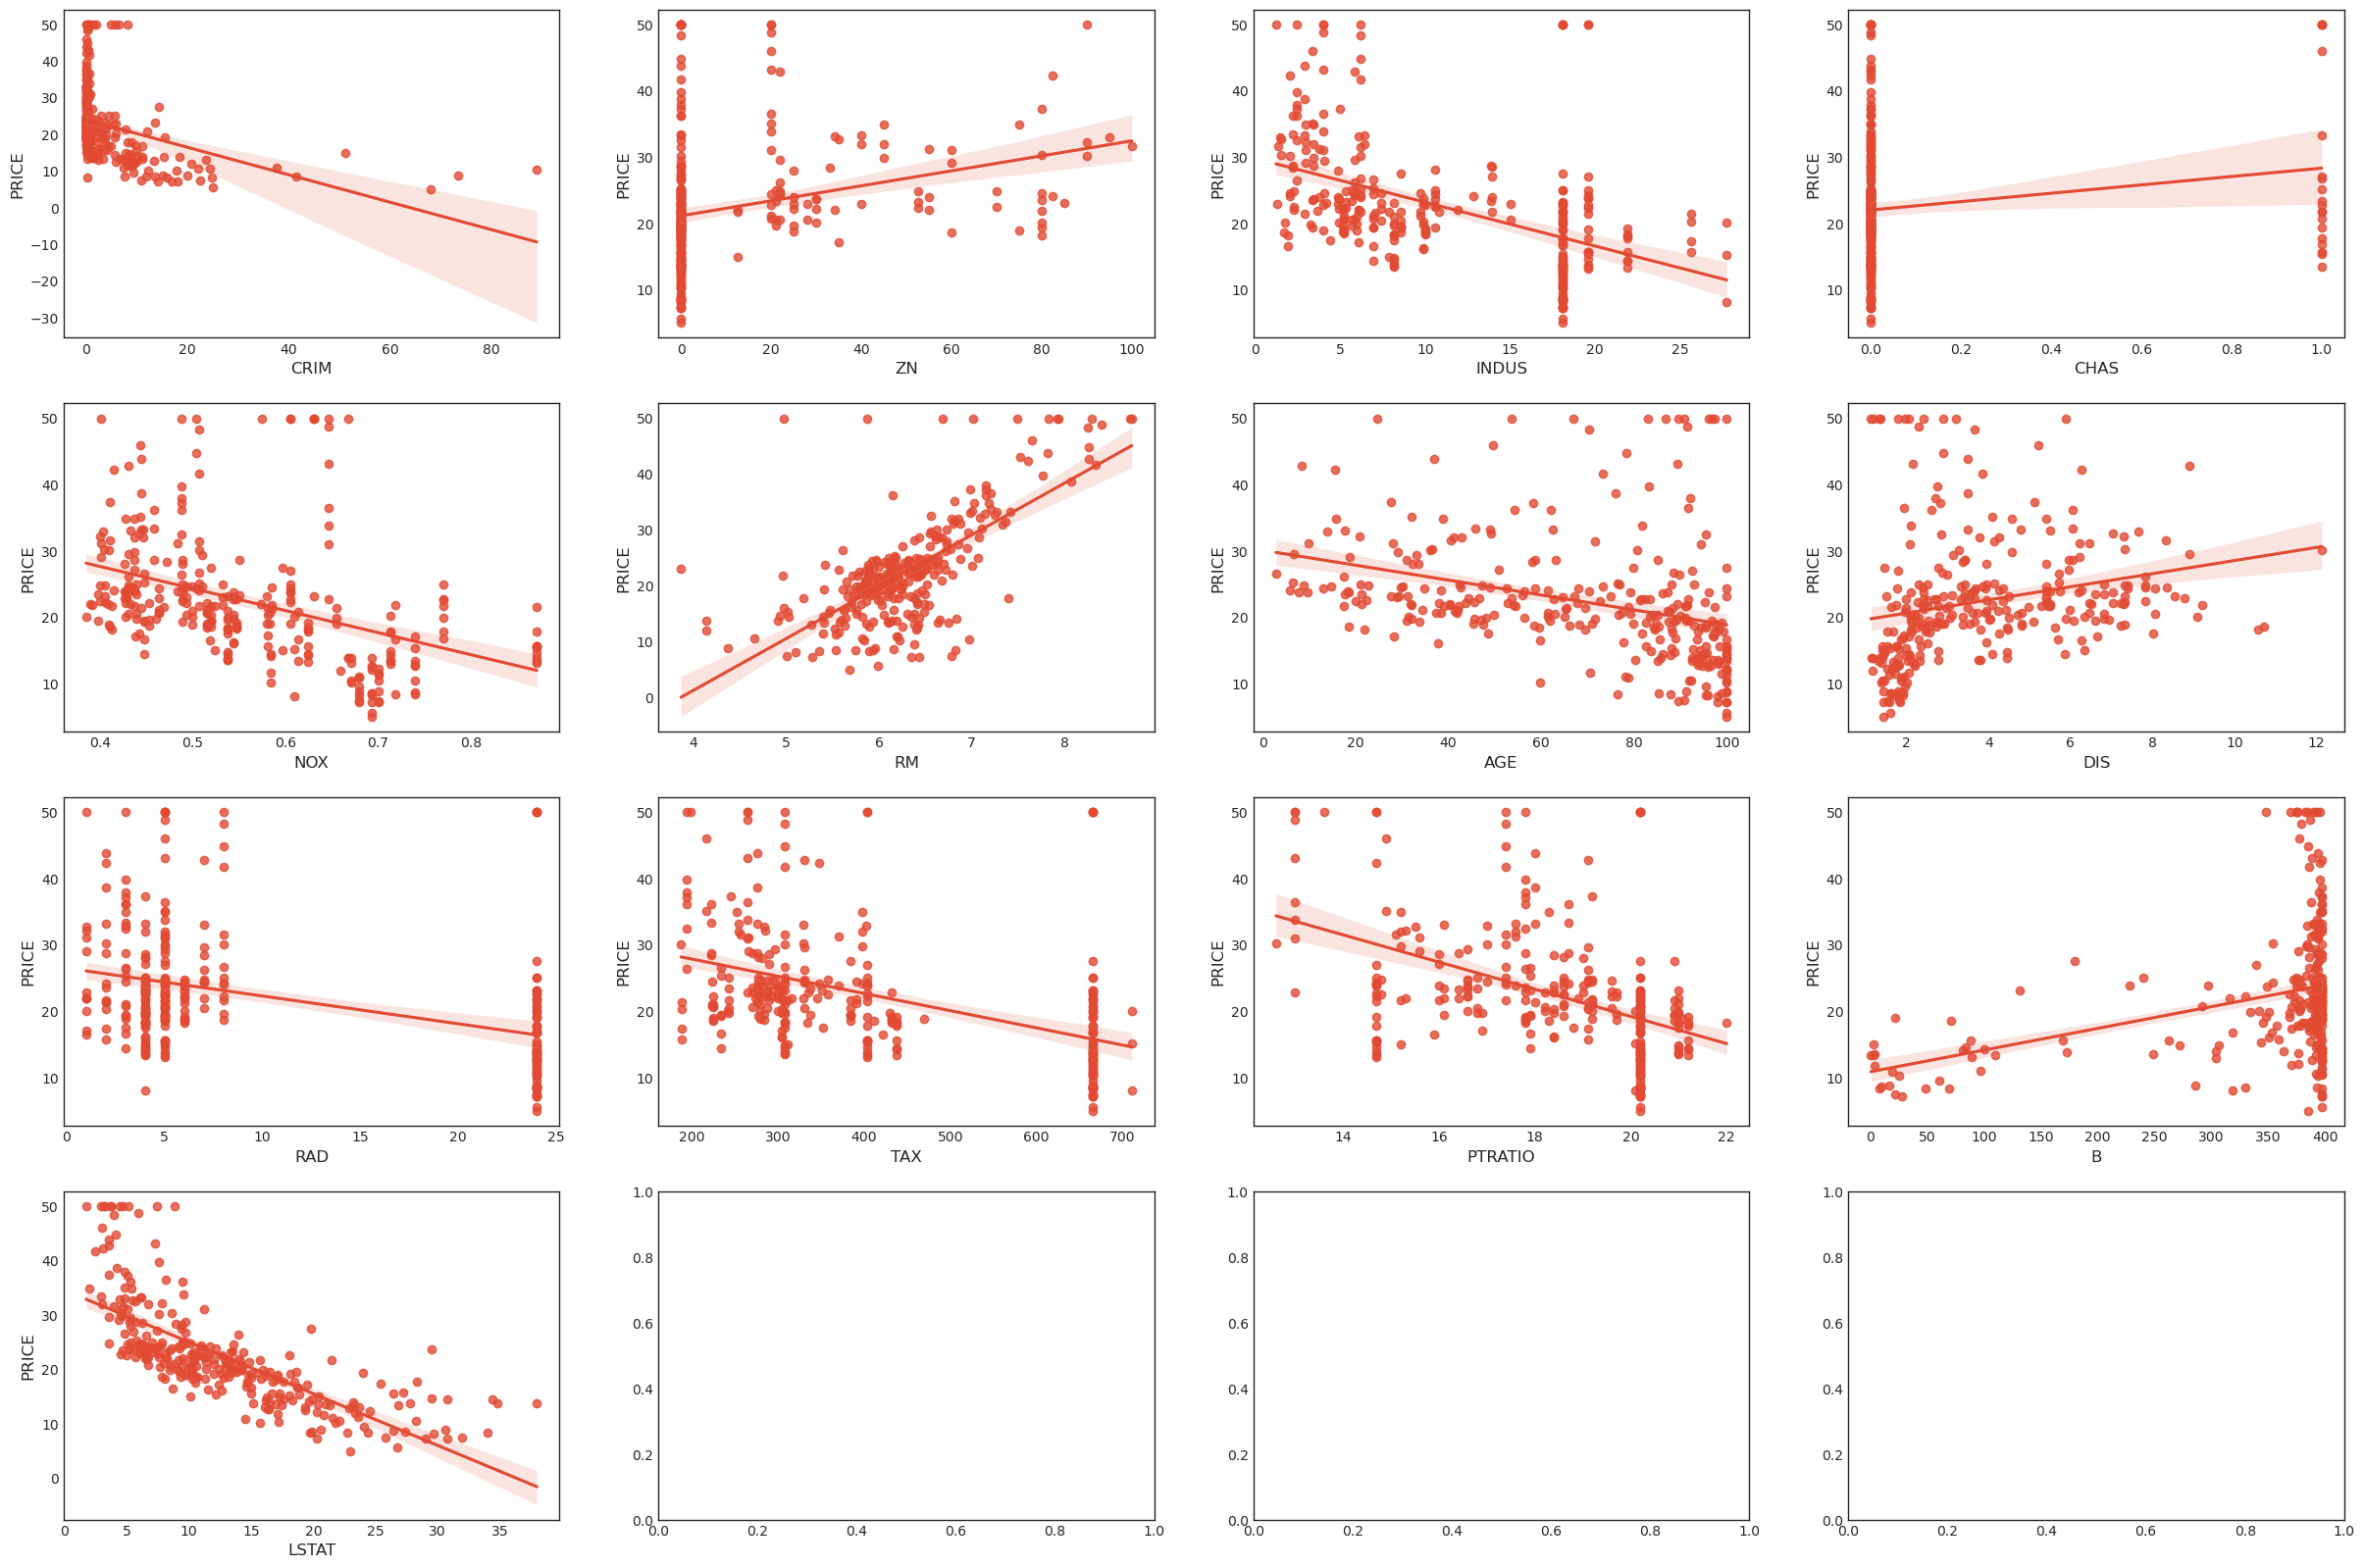

In [66]:
fig,axs = plt.subplots(figsize=(30,20),ncols=4,nrows=4)
lm_features=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']

for i,feature in enumerate(lm_features):
    row=int(i/4)    
    col=i%4

    sns.regplot(x=feature,y='PRICE',data=pd_train,ax=axs[row][col])


<AxesSubplot:>

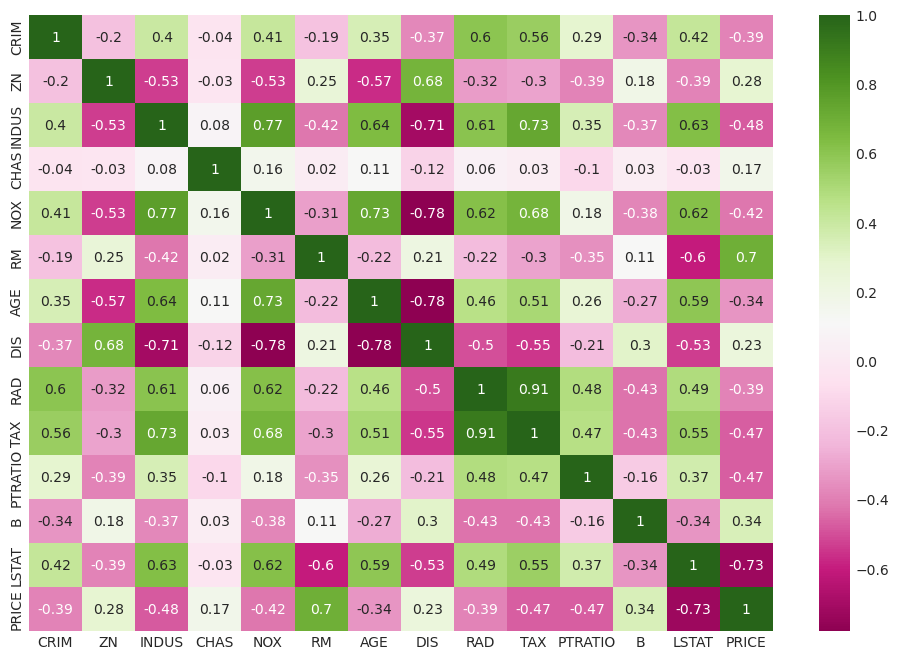

In [67]:
correlation_matrix = pd_train.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True, cmap="PiYG")

In [68]:
## scale only the training data
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(x_train)
# train_x = scaler.transform(x_train)

# val_x = scaler.transform()
# test = scaler.transform()

In [69]:
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score

def cross_val_score_model(model, x, y):
    neg_mse_scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)

    # print(f'Negative MSE scores : {np.round(neg_mse_scores, 2)}')
    # print(f'RMSE scores : {np.round(rmse_scores, 2)}')
    # print(f'Avg RMSE : {avg_rmse:.3f}')
    return avg_rmse

In [70]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()

start = datetime.now()
lin_model.fit(x_trainval, y_trainval)
finish = datetime.now()
time_orig = (finish-start).total_seconds()
print(f"elapsed time: {time_orig}")
# percentage increase
# increase = original_elapsed_time/elapsed - 1
# print(f"faster by {increase} percent")


# y_pred = lin_model.predict(x_test)

rmse_orig = cross_val_score_model(lin_model, boston.data, boston.target)
print(f"Average RMSE: {rmse_orig}")

elapsed time: 0.002958
Average RMSE: 5.8286589462158345


# Regression model을 고르는 방법에 대해서 읽고 안 것 정리
https://statisticsbyjim.com/regression/choosing-regression-analysis/

> There are numerous types of regression models that you can use. This choice often depends on the kind of data you have for the dependent variable and the type of model that provides the best fit.

**당연하겠지만, "데이터에 따라서 알맞게 골라야한다"고한다.**


## data가 continuous variable이라면 일단 linear regression 고를 수 있다. 

> However, OLS has several weaknesses, including a sensitivity to both `outliers` and `multicollinearity`, and it is prone to overfitting. To address these problems, statisticians have developed several advanced variants: `Ridge regression`, `Lasso regression`, `Partial least squares regression`.

* Ridge regression 
    * even when severe multicollinearity is present and helps prevent overfitting
* Lasso regression 
    * performs variable selection that aims to increase prediction accuracy by identifying a simpler model
    * automatic variable selection방식임
* Partial least squares (PLS) regression
    * when you have very few observations compared to the number of independent variables or when your independent variables are highly correlated.
    * PCA같은 효과가 이미 들어간 모델

> My advice is to fit a model using linear regression first and then determine whether the linear model provides an adequate fit by checking the residual plots. If you can’t obtain a good fit using linear regression, then try a nonlinear model because it can fit a wider variety of curves. I always recommend that you try OLS first because it is easier to perform and interpret.

Linear Model을 사용한 후에 다른 모델들을 시도해보아라


## 이제는 data가 categorical variables인 경우이다. 

> Logistic regression transforms the dependent variable and then uses Maximum Likelihood Estimation, rather than least squares, to estimate the parameters.

**이럴 때는 Logistic regression을 써보아라**


* Binary Logistic Regression
    * only two ouput classes: Yes, No; True, False; 0, 1, etc
* Ordinal Logistic Regression
    * An ordinal response has at least three groups which have a natural order, such as hot, medium, and cold.
* Nominal Logistic Regression
    *  A nominal variable has at least three groups which do not have a natural order, such as scratch, dent, and tear.


## data가 Count Dependent Variables인 경우에는

> If your dependent variable is a count of items, events, results, or activities, you might need to use a different type of regression model. Counts are nonnegative integers (0, 1, 2, etc.). Count data with higher means tend to be normally distributed and you can often use OLS. However, count data with smaller means can be skewed, and linear regression might have a hard time fitting these data. For these cases, there are several types of models you can use.

**count하는 것일 지라도 mean이 높냐, 낮냐에 따라서 또 다를 수 있다고함.**

* Poisson regression
    * Count data frequently follow the Poisson distribution, which makes Poisson Regression a good possibility.
    * Poisson models are similar to logistic models because they use Maximum Likelihood Estimation and transform the dependent variable using the natural log.
* Negative binomial regression
    * Poisson regression assumes that the variance equals the mean. When the variance is greater than the mean, your model has overdispersion.
* Zero-inflated models
    *  Your count data might have too many zeros to follow the Poisson distribution. In other words, there are more zeros than Poisson regression predicts.
    * Zero-inflated models assume that two separate processes work together to produce the excessive zeros. One process determines whether there are zero events or more than zero events. The other is the Poisson process that determines how many events occur, some of which can be zero.
    * Suppose park rangers count the number of fish caught by each park visitor as they exit the park. A zero-inflated model might be appropriate for this scenario because there are two processes for catching zero fish:
        * Some park visitors catch zero fish because they did not go fishing.
        * Other visitors went fishing, and some of these people caught zero fish.


# **HW5 파트 진행**

## Method 1. Feature Selection
<br>
Lasso Linear Regression Model은 특정 feature들의 coefficient가 0으로 가게끔 만들어준다. 이는 feature drop과 같은 이치인데 이것이 자동으로 되는 것이다.
<br><br>
자동으로 drop된 feature들을 실제로 빼고, Ordinary Linear Regreesion (OLR)로 돌렸을 때 같은 결과 값이 나오는지 확인해보자. 


In [71]:
from sklearn.linear_model import Lasso

lasso= Lasso()
start = datetime.now()
lasso.fit(x_train,y_train)
finish = datetime.now()
lasso_time = (finish-start).total_seconds()
print(f"lasso: {lasso_time}")
print("lasso.coef_: %s" % lasso.coef_)
print("lasso.intercept_: %s" % lasso.intercept_)
print("training set score: %f" % lasso.score(x_train, y_train))
print("test set score: %f" % lasso.score(x_test, y_test))
print("number of features used: %d" % np.sum(lasso.coef_ !=0))


# y_pred = lasso.predict(x_test)
lasso_avg_rmse = cross_val_score_model(lasso, boston.data, boston.target)
print(f"avg lasso rmse: {lasso_avg_rmse}")


lasso: 0.000927
lasso.coef_: [-0.0981344   0.03462826 -0.00450184  0.         -0.          1.6423397
  0.01621259 -0.93367501  0.22367095 -0.01347227 -0.53812891  0.01097395
 -0.76963889]
lasso.intercept_: 33.80860144145405
training set score: 0.698331
test set score: 0.659221
number of features used: 11
avg lasso rmse: 5.776020813823375


위를 보면 feature index of 2, 3, 4가 0으로 바뀌었다. `INDUS`,	`CHAS`,	`NOX`에 해당하는 것들이다. 
<br><br>
**세개의 variable을 빼고 진행해보자**

In [72]:
# feature drop index: 2,3,4
x_train_fd234 = x_train[:,[0,1,2,5,6,7,8,9,10,11,12]]
x_test_fd234  = x_test[:,[0,1,2,5,6,7,8,9,10,11,12]]
lin_model2 = LinearRegression()
start = datetime.now()
lin_model2.fit(x_train_fd234, y_train)
finish = datetime.now()

time_lin_model2 = (finish-start).total_seconds()
print(f"time_lin_model2 time: {time_lin_model2}")
# percentage increase
increase = original_elapsed_time/time_lin_model2 - 1
print(f"faster by {increase} percent")

print("lin_model2.coef_: %s" % lin_model2.coef_)
print("lin_model2.intercept_: %s" % lin_model2.intercept_)
print("training set score: %f" % lin_model2.score(x_train_fd234, y_train))
print("test set score: %f" % lin_model2.score(x_test_fd234, y_test))
print("number of features used: %d" % np.sum(lin_model2.coef_ !=0))


avg_rmse_lin_model2 = cross_val_score_model(lin_model2, boston.data, boston.target)
print(f"avg lasso rmse: {lasso_avg_rmse}")

time_lin_model2 time: 0.0018
faster by -0.15722222222222226 percent
lin_model2.coef_: [-0.13256184  0.04524607 -0.0296168   4.51739756 -0.01951924 -1.57962716
  0.25978316 -0.0141543  -0.57348278  0.01320604 -0.59210742]
lin_model2.intercept_: 18.492035956386665
training set score: 0.736945
test set score: 0.634912
number of features used: 11
avg lasso rmse: 5.776020813823375


In [73]:
from itertools import combinations
arr = [0,1,2,3,4,5,6,7,8,9,10,11,12]
comb = []
for i in range(12):
    comb += combinations(arr,i)
print(len(comb))

start  = datetime.now()

n = 0
avg_rmse_collection = []
for selected in comb:
    print(f"{n}/8194")
    n += 1
    if len(list(selected)) != 0:
        dumb_model = LinearRegression()
        x_train_fd = x_train[:,list(selected)]
        x_trainval_fd = x_trainval[:,list(selected)]
        #x_val_fd = x_val[:,list(selected)]
        x_test_fd  = x_test[:,list(selected)]
        dumb_model.fit(x_train_fd,y_train)
        ans  = cross_val_score_model(dumb_model, x_trainval_fd, y_trainval)
        avg_rmse_collection.append(ans)

finish  = datetime.now()
total_time = (finish - start).total_seconds()
print(f"totaltime: {total_time}")


8178
0/8194
1/8194
2/8194
3/8194
4/8194
5/8194
6/8194
7/8194
8/8194
9/8194
10/8194
11/8194
12/8194
13/8194
14/8194
15/8194
16/8194
17/8194
18/8194
19/8194
20/8194
21/8194
22/8194
23/8194
24/8194
25/8194
26/8194
27/8194
28/8194
29/8194
30/8194
31/8194
32/8194
33/8194
34/8194
35/8194
36/8194
37/8194
38/8194
39/8194
40/8194
41/8194
42/8194
43/8194
44/8194
45/8194
46/8194
47/8194
48/8194
49/8194
50/8194
51/8194
52/8194
53/8194
54/8194
55/8194
56/8194
57/8194
58/8194
59/8194
60/8194
61/8194
62/8194
63/8194
64/8194
65/8194
66/8194
67/8194
68/8194
69/8194
70/8194
71/8194
72/8194
73/8194
74/8194
75/8194
76/8194
77/8194
78/8194
79/8194
80/8194
81/8194
82/8194
83/8194
84/8194
85/8194
86/8194
87/8194
88/8194
89/8194
90/8194
91/8194
92/8194
93/8194
94/8194
95/8194
96/8194
97/8194
98/8194
99/8194
100/8194
101/8194
102/8194
103/8194
104/8194
105/8194
106/8194
107/8194
108/8194
109/8194
110/8194
111/8194
112/8194
113/8194
114/8194
115/8194
116/8194
117/8194
118/8194
119/8194
120/8194
121/8194
122/819

In [74]:
min(avg_rmse_collection)

4.8099132834941

In [75]:
found = avg_rmse_collection.index(min(avg_rmse_collection))
print(f"best selection: {comb[found]}")

best selection: (0, 3, 4, 5, 6, 8, 9, 10, 11, 12)


In [76]:
found

8029

In [77]:
chosen = comb[found]
model_fd = LinearRegression()
start = datetime.now()
model_fd.fit(x_trainval[:,chosen], y_trainval)
finish = datetime.now()
time_1 = (finish-start).total_seconds()
ans  = cross_val_score_model(model_fd, boston.data[:,chosen], boston.target)
print(f"best linear regression by Feature Selection {ans}")
bytes_1 = boston.data[:,chosen].nbytes
print(f"compression: {bytes_orig/bytes_1*100}")
print(f"time increase by {(time_orig/time_1 - 1)*100}")


best linear regression by Feature Selection 6.0001277247144795
compression: 130.0
time increase by 67.3076923076923


**분석**
* 모든 combination의 feature selection으로 validation result가 가장 잘 나오는 것을 토대로 model을 fit 하여 사용해보았지만 결국에는 모든 feature을 쓰는 것이 더 좋은 linear regression 결과를 보였다
* feature selection은 결국에 이런식으로 모든 경우의 수를 탐구한다고 한들 의미가 없다. 왜냐하면 보다시피 더 좋은 feature selection으로 이어지지 않는다. 결국에는 correlation matrix를 보고 뺄 것은 적당히 빼는 사람의 판단이 필요하다
* 

## Method 2: PCA

In [78]:
from sklearn.decomposition import PCA
scores = []
for n_comp in range(1,14):
    pca = PCA(n_components = n_comp)
    new_data = pca.fit_transform(boston.data)
    x_trainval, x_test, y_trainval, y_test = train_test_split(new_data, boston.target, test_size=0.2, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.25, random_state=13)
    model = LinearRegression()
    model.fit(x_train, y_train)
    score = cross_val_score_model(model, x_val, y_val)
    scores.append(score)

print(f"best is with n_components of {scores.index(min(scores))+1}")

best is with n_components of 12


In [59]:
print(scores)

[7.876122335219239, 7.894315642501729, 7.464211933038575, 7.496033373546051, 7.624323986574451, 5.929454455790625, 5.788518083375048, 5.7884036790500195, 5.168008614012469, 5.2637876083642645, 4.546268701953291, 4.709333298027138, 4.538486359256991]


In [79]:
print(scores)

[7.876122335219239, 7.894315642501729, 7.464211933038575, 7.496033373546051, 7.624323986574453, 5.929454455790623, 5.788518083375048, 5.78840367905002, 5.16800861401247, 5.263787608364265, 4.546268701953291, 4.709333298027138, 4.538486359256991]


In [83]:
pca = PCA(n_components=10)
new_data = pca.fit_transform(boston.data)
x_trainval, x_test, y_trainval, y_test = train_test_split(new_data, boston.target, test_size=0.2, random_state=42)
model_pca = LinearRegression()
start = datetime.now()
model_pca.fit(x_trainval, y_trainval)
finish = datetime.now()
time_2 = (finish-start).total_seconds()
ans  = cross_val_score_model(model_pca, new_data, boston.target)
print(f"best linear regression by PCA {ans}")
bytes_2 = new_data.nbytes
print(f"compression: {bytes_orig/bytes_2*100}")
print(f"time increase by {(time_orig/time_2 - 1)*100}")

best linear regression by PCA 5.445400202693344
compression: 130.0
time increase by 303.5470668485675


In [88]:
time_2

0.000733

In [87]:
(5.8286589462158345 - 5.445400202693344)/5.8286589462158345*100

6.575418926703803

**분석**
* PCA compression은 feature selection보다 좋은 결과를 보여줌. (6.00 -> 5.45)
* 또, 시간이 압도적으로 빨라짐: (67 퍼센트 증가 -> 303 퍼센트 증가)
* feature selection보다 pca compression이 좋음. 

## Method 3: Factor Analysis

In [84]:
from sklearn.decomposition import FactorAnalysis


scores = []
for n_comp in range(1,14):
    fa = FactorAnalysis(n_components = n_comp)
    new_data = fa.fit_transform(boston.data)
    x_trainval, x_test, y_trainval, y_test = train_test_split(new_data, boston.target, test_size=0.2, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.25, random_state=13)
    model = LinearRegression()
    model.fit(x_train, y_train)
    score = cross_val_score_model(model, x_val, y_val)
    scores.append(score)

print(f"best is with n_components of {scores.index(min(scores))+1}")



best is with n_components of 11


In [85]:
scores

[7.299191829535121,
 7.920045421978938,
 7.556976778519525,
 7.522127673643567,
 7.603370282522353,
 4.89908860451362,
 4.7188070468986085,
 4.677517649864686,
 5.407371710089298,
 5.254470970885334,
 4.410151116472669,
 4.508642935403493,
 4.671766196757254]

In [86]:
fa = FactorAnalysis(n_components = 10)
new_data = fa.fit_transform(boston.data)
x_trainval, x_test, y_trainval, y_test = train_test_split(new_data, boston.target, test_size=0.2, random_state=42)

model = LinearRegression()
start = datetime.now()
model.fit(x_trainval, y_trainval)
finish = datetime.now()
score = cross_val_score_model(model, x_test, y_test)
time_3 = (finish-start).total_seconds()
ans  = cross_val_score_model(model_pca, new_data, boston.target)
print(f"best linear regression by PCA {ans}")
bytes_3 = new_data.nbytes
print(f"compression: {bytes_orig/bytes_3*100}")
print(f"time increase by {(time_orig/time_3 - 1)*100}")

best linear regression by PCA 5.498632478212004
compression: 130.0
time increase by 191.1417322834646


**분석**
* FA로 compress한건 그렇게 빠르진 않네
* 